In [64]:
pip install pykalman

  Using cached pykalman-0.9.7-py2.py3-none-any.whl.metadata (5.5 kB)
Using cached pykalman-0.9.7-py2.py3-none-any.whl (251 kB)
Note: you may need to restart the kernel to use updated packages.


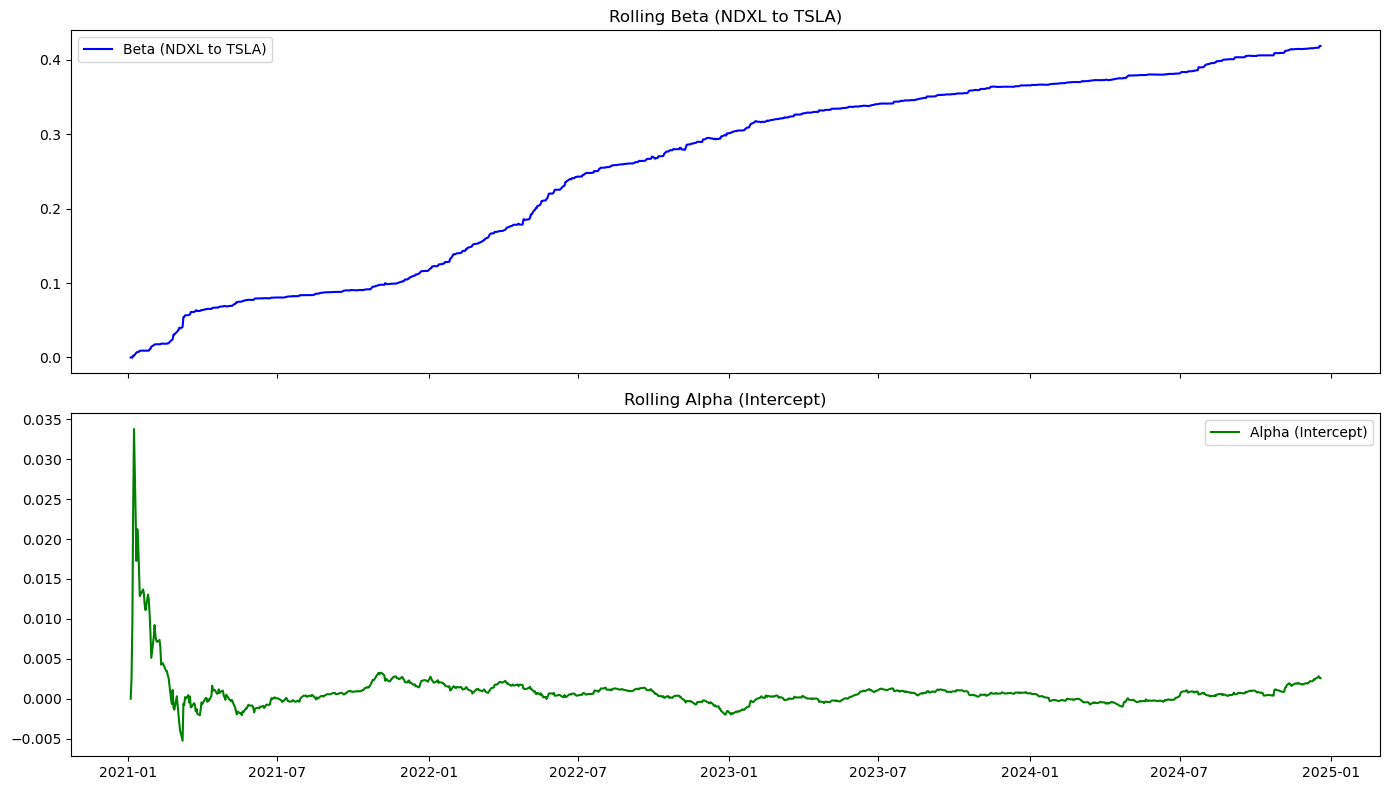

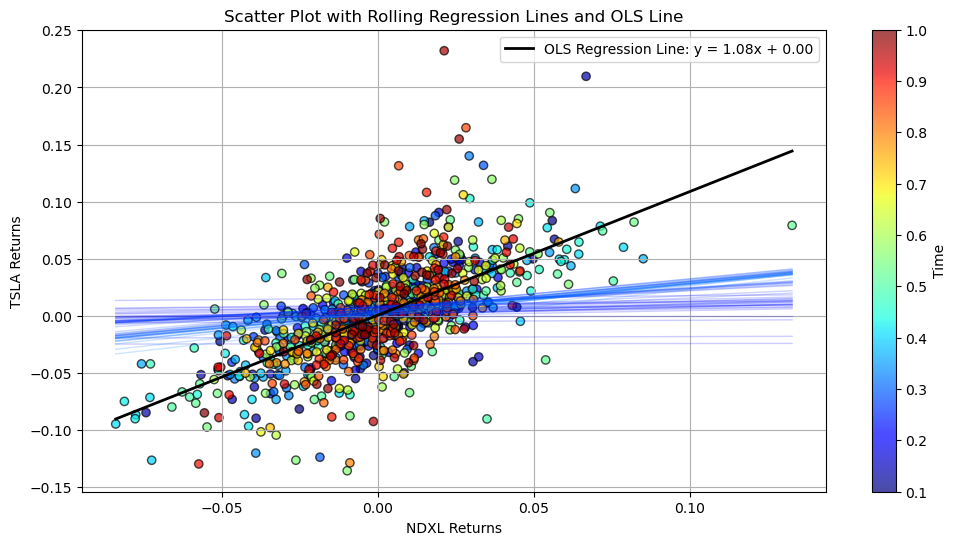

DataFrame shape: (998, 4)
Date range in data: 2021-01-04 05:00:00 to 2024-12-19 05:00:00
State means shape: (1665, 2)
Number of data points in returns: 998


In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Load data and ensure proper datetime parsing
tsla_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/TSLA_Normalised_OHLC_VWAP_VOL.csv')
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'], errors='coerce', utc=True)
tsla_data.set_index('Date', inplace=True)
tsla_data.index = tsla_data.index.tz_convert(None)

ndxl_data = pd.read_csv('/Users/jivenchana/Documents/TSLA-Model-v1.6/DataCsv/NDXL_Normalised_OHLC_VWAP_VOL.csv')
ndxl_data['Date'] = pd.to_datetime(ndxl_data['Date'], errors='coerce', utc=True)
ndxl_data.set_index('Date', inplace=True)
ndxl_data.index = ndxl_data.index.tz_convert(None)

# Filter data to include only observations from 2021 to 2024
start_date = '2021-01-01'
end_date = '2024-12-31'
tsla_data = tsla_data[start_date:end_date]
ndxl_data = ndxl_data[start_date:end_date]

# Ensure both datasets are aligned by date and check for non-finite values
data = pd.concat([tsla_data['Close_Price'], ndxl_data['Close_Price']], axis=1).dropna()
data.columns = ['TSLA', 'NDXL']

# Ensure no inf or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Calculate returns
data['TSLA_returns'] = data['TSLA'].pct_change().fillna(0)
data['NDXL_returns'] = data['NDXL'].pct_change().fillna(0)

# Observation matrix
obs_mat = np.vstack([data['NDXL_returns'], np.ones(len(data['NDXL_returns']))]).T

# Initialize the Kalman Filter
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance
kf = KalmanFilter(
    n_dim_obs=1,  # y is 1-dimensional (TSLA returns)
    n_dim_state=2,  # state is 2-dimensional (beta and alpha)
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat[:, np.newaxis],
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

# Manually update the filter for each time point with error handling
n_timesteps = len(data)
means = np.zeros((n_timesteps, 2))
covariances = np.zeros((n_timesteps, 2, 2))

for i in range(n_timesteps):
    try:
        if i == 0:
            means[i], covariances[i] = kf.filter_update(
                kf.initial_state_mean,
                kf.initial_state_covariance,
                observation=data['TSLA_returns'].iloc[i],
                observation_matrix=obs_mat[i, np.newaxis]
            )
        else:
            means[i], covariances[i] = kf.filter_update(
                means[i-1],
                covariances[i-1],
                observation=data['TSLA_returns'].iloc[i],
                observation_matrix=obs_mat[i, np.newaxis]
            )
    except Exception as e:
        print(f"Error at step {i}: {str(e)}")
        means[i] = means[i-1]  # Reset to last valid state
        covariances[i] = covariances[i-1] * 10  # Increase uncertainty

# Print the filtered state for each step
    #print(f"Step {i}: Beta = {means[i, 0]}, Alpha = {means[i, 1]}")

# Plotting Beta and Alpha over time
_, axarr = plt.subplots(2, sharex=True, figsize=(14, 8))
axarr[0].plot(data.index, means[:, 0], label='Beta (NDXL to TSLA)', color='blue')
axarr[0].set_title('Rolling Beta (NDXL to TSLA)')
axarr[0].legend()
axarr[1].plot(data.index, means[:, 1], label='Alpha (Intercept)', color='green')
axarr[1].set_title('Rolling Alpha (Intercept)')
axarr[1].legend()
plt.tight_layout()
plt.show()

# Scatter plot with regression lines
plt.figure(figsize=(12, 6))
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data['NDXL_returns'], data['TSLA_returns'], c=colors, cmap='jet', edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.set_label('Time')

# Add every 5th regression line
step = 5
xi = np.linspace(data['NDXL_returns'].min(), data['NDXL_returns'].max(), 100)
colors_step = np.linspace(0.1, 1, len(state_means[::step]))
for i, (beta, alpha) in enumerate(state_means[::step]):
    yi = beta * xi + alpha
    plt.plot(xi, yi, alpha=0.2, lw=1, color=plt.cm.jet(colors_step[i]))

# Add OLS regression line for comparison
ols_beta, ols_alpha = np.polyfit(data['NDXL_returns'], data['TSLA_returns'], 1)
ols_line = ols_beta * xi + ols_alpha
plt.plot(xi, ols_line, color='black', lw=2, label=f'OLS Regression Line: y = {ols_beta:.2f}x + {ols_alpha:.2f}')

plt.xlabel('NDXL Returns')
plt.ylabel('TSLA Returns')
plt.legend()
plt.grid(True)
plt.title('Scatter Plot with Rolling Regression Lines and OLS Line')
plt.show()

print("DataFrame shape:", data.shape)
print("Date range in data:", data.index.min(), "to", data.index.max())

print("State means shape:", state_means.shape)
print("Number of data points in returns:", len(data['TSLA_returns']))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter